<a href="https://colab.research.google.com/github/ngcheeyuan/Fraud_Detection_Capstone/blob/main/Capstone_Base_Model_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U scikit-learn
!pip install -U imbalanced-learn
!pip install plot_metric
!pip install category_encoders

     |████████████████████████████████| 82 kB 374 kB/s 


In [ ]:
#preprocessing, pipelining
from sklearn.preprocessing import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import make_column_transformer , make_column_selector
from sklearn.metrics import balanced_accuracy_score , precision_score , recall_score , f1_score
from sklearn.pipeline import make_pipeline

#utility
import pandas as pd
import numpy as np

#models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

#plotting
from plot_metric.functions import BinaryClassification
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_tree
from xgboost import to_graphviz

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def evaluation_plot(model,X_tr,X_t,y_tr,y_t):

  train_preds = model.predict(X_tr)
  test_preds = model.predict(X_t)

  train_proba= model.predict_proba(X_tr)
  test_proba = model.predict_proba(X_t)

  print_results(model,X_tr,X_t,y_tr,y_t)

  plt.figure(figsize=(24,12))
  bc = BinaryClassification(y_tr, train_proba[::,1], labels=["Not Fraud", "Fraud"])
  bc1 = BinaryClassification(y_t, test_proba[::,1], labels=["Not Fraud", "Fraud"])

  #plotting ROC-AUC curve
  plt.subplot2grid(shape=(3,12), loc=(0,0), colspan=3)
  bc.plot_roc_curve(title = 'Training - ROC')
  plt.subplot2grid(shape=(3,12), loc=(0,3), colspan=3)
  bc1.plot_roc_curve(title  = 'Testing - ROC')
  
  #plotting Precission-recall curve
  plt.subplot2grid((3,12), (1,0), colspan=3)
  bc.plot_precision_recall_curve(title = 'Training - Precision -Recall Curve')
  plt.subplot2grid((3,12), (1,3), colspan=3)
  bc1.plot_precision_recall_curve(title = 'Testing - Precision -Recall Curve')

  #plot confusion matrix
  plt.subplot2grid((3,12), (0,6), colspan=3)
  bc.plot_confusion_matrix(title ='Training')
  plt.subplot2grid((3,12), (0,9), colspan=3)
  bc1.plot_confusion_matrix(title = 'Testing')

  #plot confusion matrix with the values normalized
  plt.subplot2grid((3,12), (1,6), colspan=3)
  bc.plot_confusion_matrix(title ='Training' , normalize = True)
  plt.subplot2grid((3,12), (1,9), colspan=3)
  bc1.plot_confusion_matrix(title = 'Testing', normalize = True)

  plt.subplot2grid((3,12), (2,3), colspan=3)
  bc.plot_class_distribution(title ='Training')
  plt.subplot2grid((3,12), (2,6), colspan=3)
  bc1.plot_class_distribution(title = 'Testing')


In [ ]:
def print_results(model,X_tr,X_t,y_tr,y_t):
  train_preds = model.predict(X_tr)
  test_preds = model.predict(X_t)

  train_acc = balanced_accuracy_score(y_tr,train_preds)
  train_prec = precision_score(y_tr,train_preds)
  train_rec = recall_score(y_tr,train_preds)
  train_f1 = f1_score(y_tr,train_preds)

  test_acc = balanced_accuracy_score(y_t,test_preds)
  test_prec = precision_score(y_t,test_preds)
  test_rec = recall_score(y_t,test_preds)
  test_f1 = f1_score(y_t,test_preds)

  print(f'train - balanced acc : {train_acc} , precision : {train_prec} , recall: {train_rec}, f1: {train_f1}')
  print(f'test - balanced acc : {test_acc} , precision : {test_prec} , recall: {test_rec}, f1: {test_f1}')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Capstone Dataset/train_engineered.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Capstone Dataset/test_engineered.csv')

In [ ]:
df_train.fillna(0,inplace = True )
df_test.fillna(0,inplace = True )

In [ ]:
df_train['trans_date_time'] = pd.to_datetime(df_train['trans_date_time'])
df_train.set_index('trans_date_time',inplace = True)
df_test['trans_date_time'] = pd.to_datetime(df_test['trans_date_time'])
df_test.set_index('trans_date_time',inplace = True)

In [ ]:
features = ['cc_num','category','amt','merchant','trans_year',
            'trans_month','age_at_trans','weekday','day']

In [ ]:
X_train = df_train.loc[:,features].copy()
y_train = df_train.loc[:,'is_fraud'].copy()

'''
X_val = df_val.loc[:,features].copy()
X_val['job'] = X_val['job'].astype('category')
X_val['merchant'] = X_val['job'].astype('category')
X_val['cc_num'] = X_val['cc_num'].astype('category')
y_val = df_val.loc[:,'is_fraud'].copy()
'''

X_test = df_test.loc[:,features].copy()
#X_test = X_test.loc['2013-01-01':'2013-01-31'].reset_index(drop=True)
y_test= df_test.loc[:,'is_fraud'].copy()
#y_test = y_test.loc['2013-01-01':'2013-01-31'].reset_index(drop=True)

In [ ]:
ohe = OneHotEncoder()
tgt = TargetEncoder(smoothing = 50)
ctf = make_column_transformer((ohe,make_column_selector(dtype_include = object)),
                              remainder = 'passthrough')


#weight = len(df_train[df_train['is_fraud']==0])/len(df_train[df_train['is_fraud']==1])

dummy_model = make_pipeline(ctf,DummyClassifier())
log_model = make_pipeline(ctf, LogisticRegression(class_weight='balanced'))
xgboost_model = make_pipeline(ctf, XGBClassifier(scale_pos_weight = 1, 
                                                 max_depth = 3, 
                                                 gamma = 150 , 
                                                 min_child_weight = 150,
                                                 tree_method = 'hist',
                                                 ))

In [ ]:
dummy_model.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f0a21130510>)])),
                ('dummyclassifier', DummyClassifier())])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train - balanced acc : 0.5 , precision : 0.0 , recall: 0.0, f1: 0.0
test - balanced acc : 0.5 , precision : 0.0 , recall: 0.0, f1: 0.0


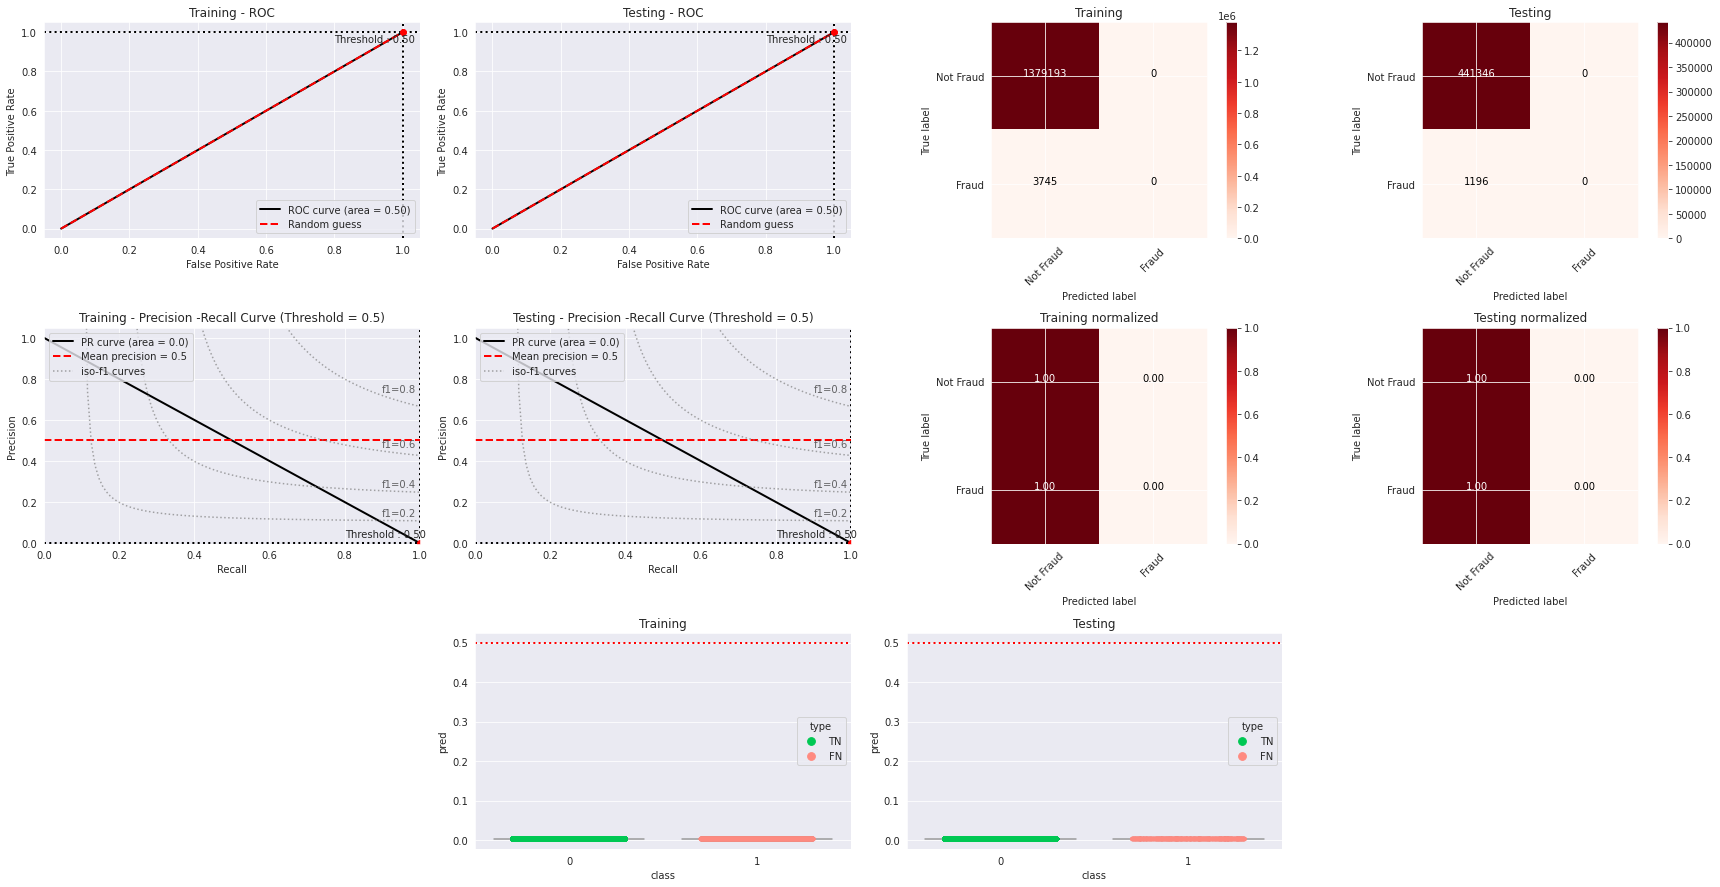

In [ ]:
evaluation_plot(dummy_model,X_train,X_test,y_train,y_test)

In [ ]:
log_model.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f0a21130510>)])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced'))])

train - balanced acc : 0.5 , precision : 0.0027080028171906478 , recall: 1.0, f1: 0.00540137868568375
test - balanced acc : 0.5 , precision : 0.0027025683437956172 , recall: 1.0, f1: 0.005390568308326084


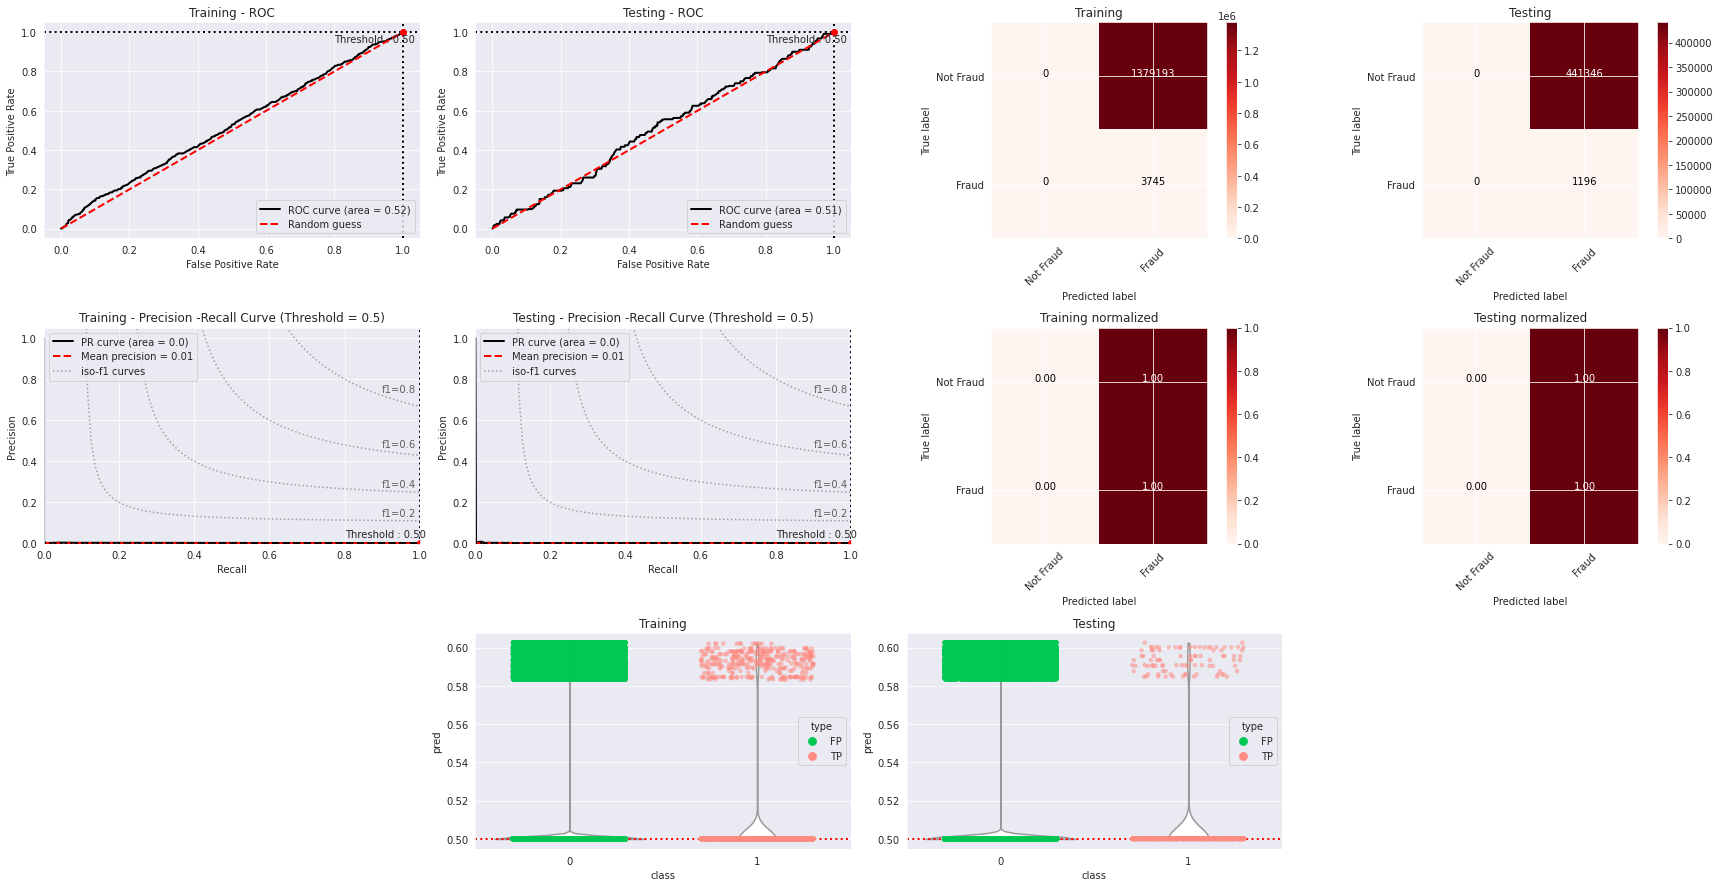

In [ ]:
evaluation_plot(log_model,X_train,X_test,y_train,y_test)

In [ ]:
xgboost_model.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f0a21130510>)])),
                ('xgbclassifier',
                 XGBClassifier(gamma=150, min_child_weight=150,
                               tree_method='hist'))])

train - balanced acc : 0.6059916967930039 , precision : 0.9463647199046484 , recall: 0.21201602136181574, f1: 0.34642233856893545
test - balanced acc : 0.6141089097206391 , precision : 0.934931506849315 , recall: 0.22826086956521738, f1: 0.3669354838709677


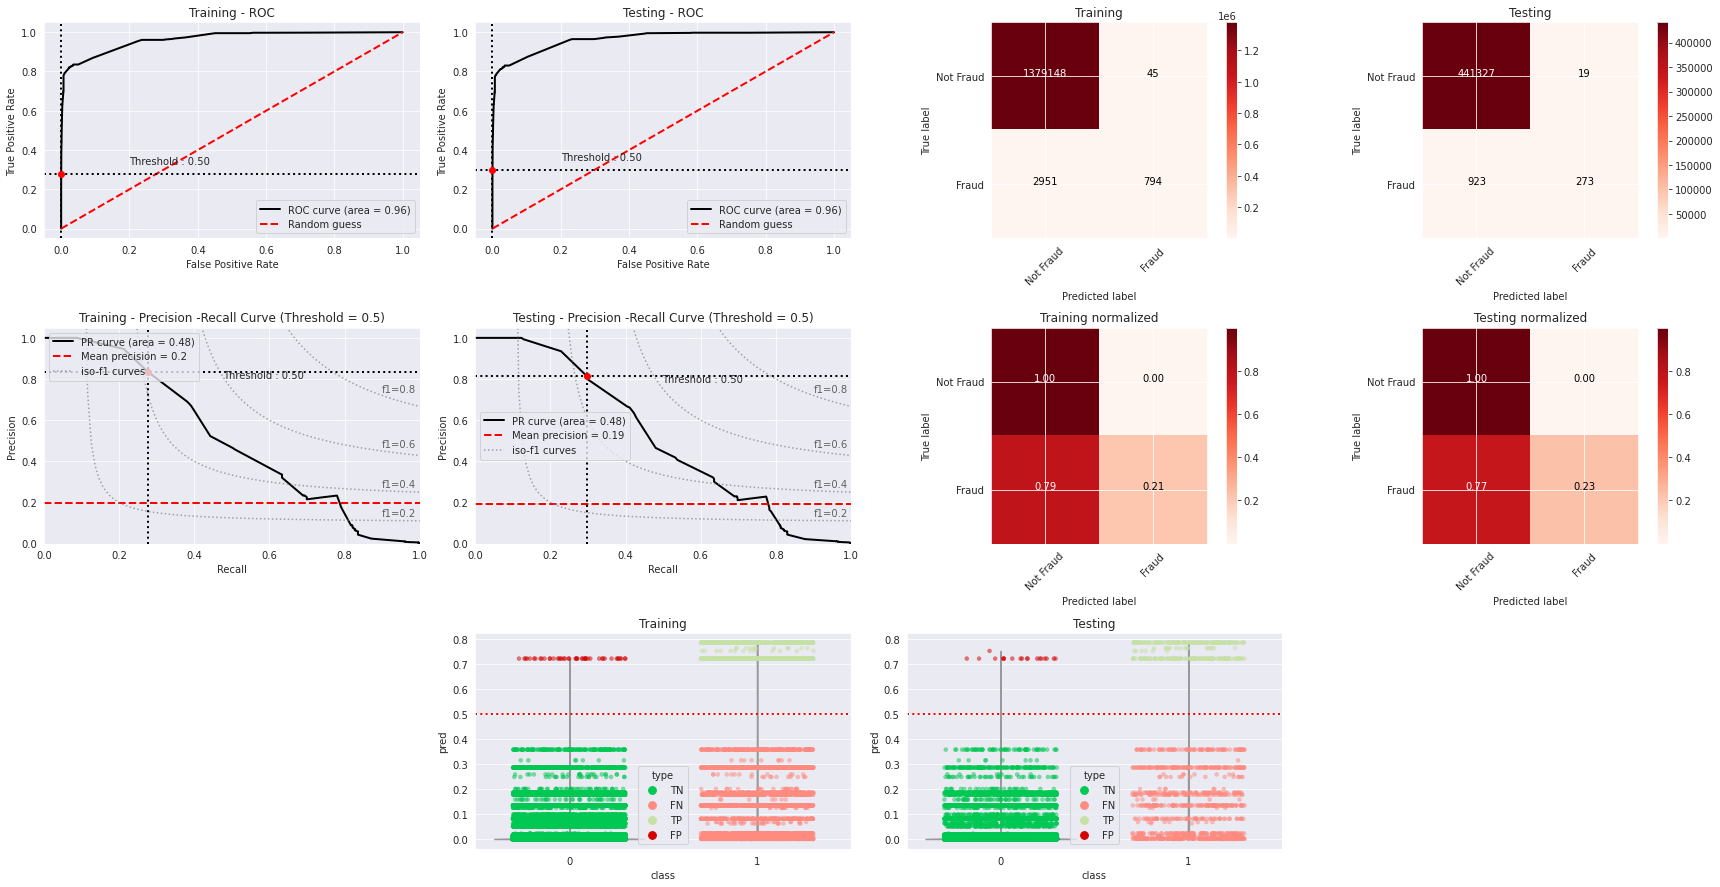

In [ ]:
   evaluation_plot(xgboost_model,X_train,X_test,y_train,y_test)

1. XGBoost clearly performed much better than the other 2 models.

2. Dummy Classifier and Logistic regression performed no better than a coin flip.

### Error Analysis

In [ ]:
train_proba = xgboost_model.predict_proba(X_train)
train_prob = xgboost_model.predict(X_train)

In [ ]:
df_ea = pd.DataFrame({'proba':train_proba[::,1],
                      'predictions':train_prob,
                      'actual':y_train})

In [ ]:
df_ea.reset_index(drop = True, inplace = True)

Text(0, 0.5, 'False Positive')

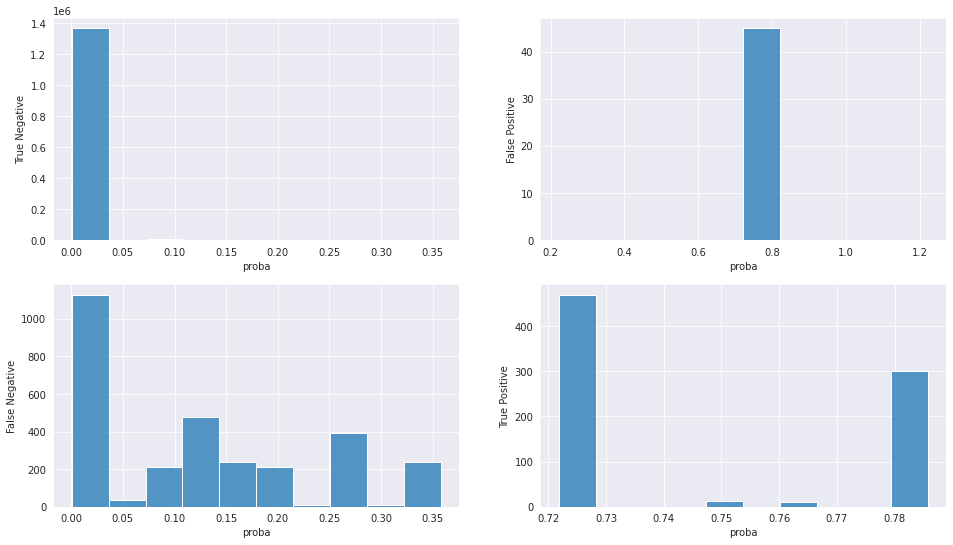

In [ ]:
fig,ax = plt.subplots(2,2, figsize = (16,9))

data = df_ea.loc[(df_ea['predictions']==0)&
                 (df_ea['predictions']==df_ea['actual'])].sort_values(by = 'proba' )

sns.histplot(data = data , x = 'proba', bins =10 , ax = ax[0,0])
ax[0,0].set_ylabel('True Negative')

data = df_ea.loc[(df_ea['predictions']==1)&
                 (df_ea['predictions']==df_ea['actual'])].sort_values(by = 'proba')

sns.histplot(data = data , x = 'proba', bins =10 , ax = ax[1,1])
ax[1,1].set_ylabel('True Positive')

data = df_ea.loc[(df_ea['predictions']==0)&
                 (df_ea['predictions']!=df_ea['actual'])].sort_values(by = 'proba' )

sns.histplot(data = data , x = 'proba', bins=10, ax = ax[1,0])
ax[1,0].set_ylabel('False Negative')

data = df_ea.loc[(df_ea['predictions']==1)&
                 (df_ea['predictions']!=df_ea['actual'])].sort_values(by = 'proba' )

sns.histplot(data = data , x = 'proba', bins=10, ax = ax[0,1]);
ax[0,1].set_ylabel('False Positive')

1. The model seems to be fairly confident with it's prediction for non-fraudulent cases, where the predicted probability largely is below 5%.

2. A majority of the false negative prediction made by the model are close to proba = 0

In [ ]:
fn_exp =\
df_train.iloc[df_ea.loc[(df_ea['predictions']==0)&
                        (df_ea['proba']<0.05)&
                        (df_ea['predictions']!=df_ea['actual'])].sort_values(by = 'proba' ).index][features]

In [ ]:
xgboost_model.steps[1][1].get_booster().feature_names = xgboost_model.steps[0][1].get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


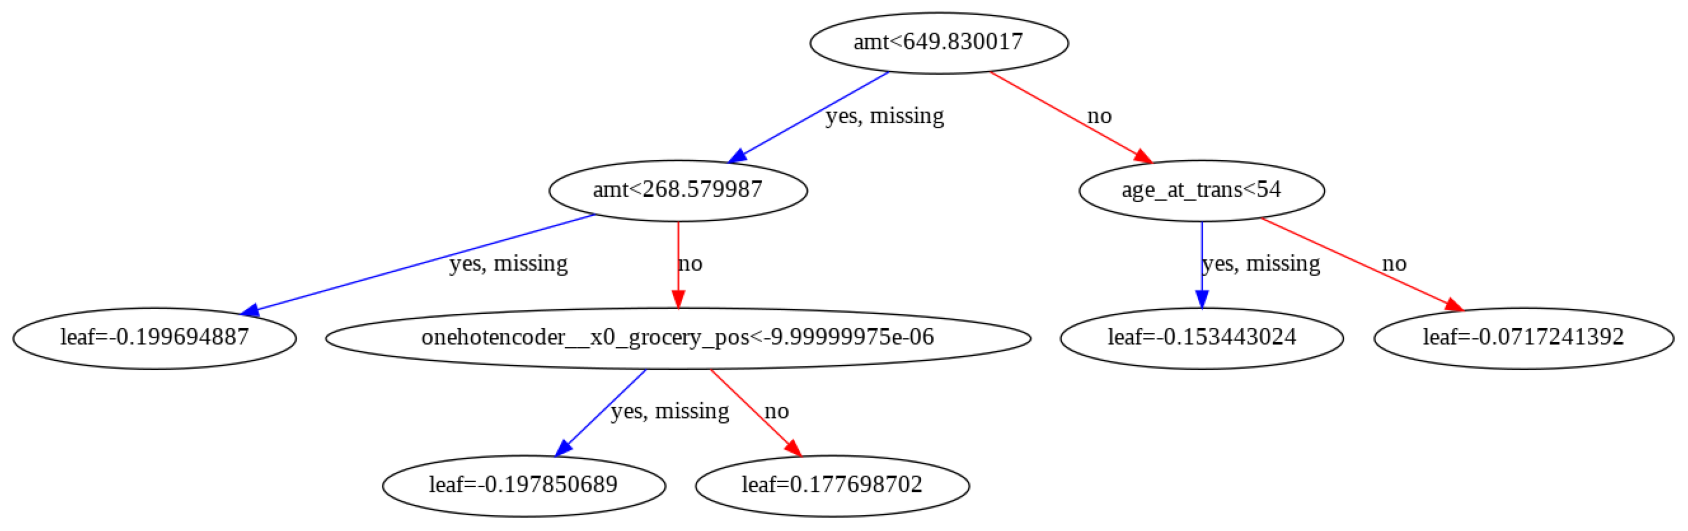

In [ ]:
fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(xgboost_model.steps[1][1] , ax = ax)

In [ ]:
Feature_importance = pd.DataFrame({'feature':xgboost_model.steps[0][1].get_feature_names(),
                                   'importance':xgboost_model.steps[1][1].feature_importances_}).sort_values(by = 'importance', ascending = False)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


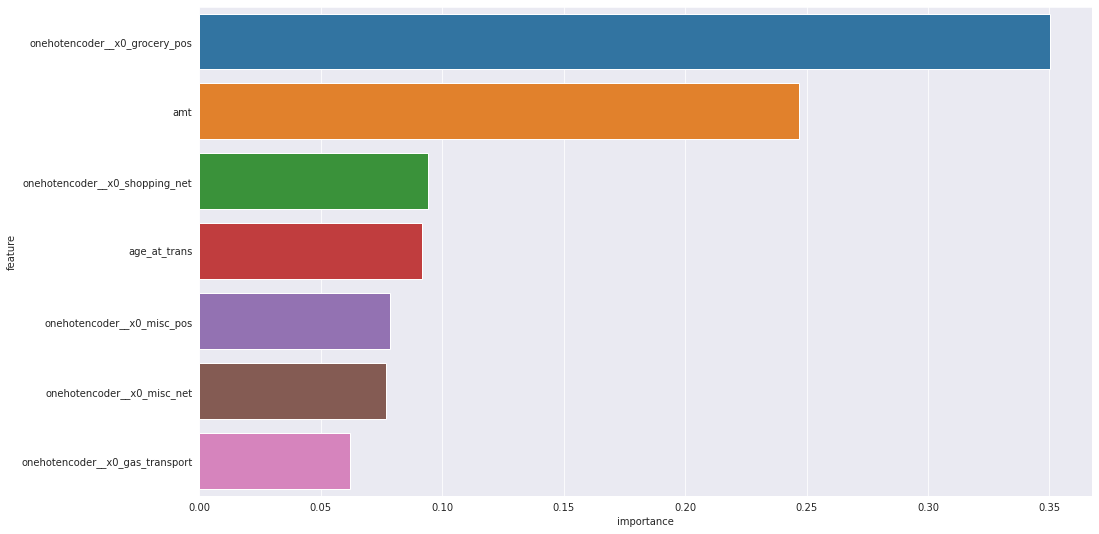

In [ ]:
fig,ax = plt.subplots(figsize = (16,9))
mask = Feature_importance['importance']>0
sns.barplot(data = Feature_importance[mask] , x = 'importance' , y ='feature', orient ='h' , ax = ax)